# U.S. Geological Survey Class GW3099
Advanced Modeling of Groundwater Flow (GW3099)\
Boise, Idaho\
September 16 - 20, 2024

![title](../../images/ClassLocation.jpg)

# Explore SFR diversions - Part 3

This example is a modified version of the Streamflow Routing (SFR) Package described in [Prudic et al., (2004)](https://doi.org/10.3133/ofr20041042). The problem has been modified by converting all of the SFR reaches to use rectangular channels.

<div>
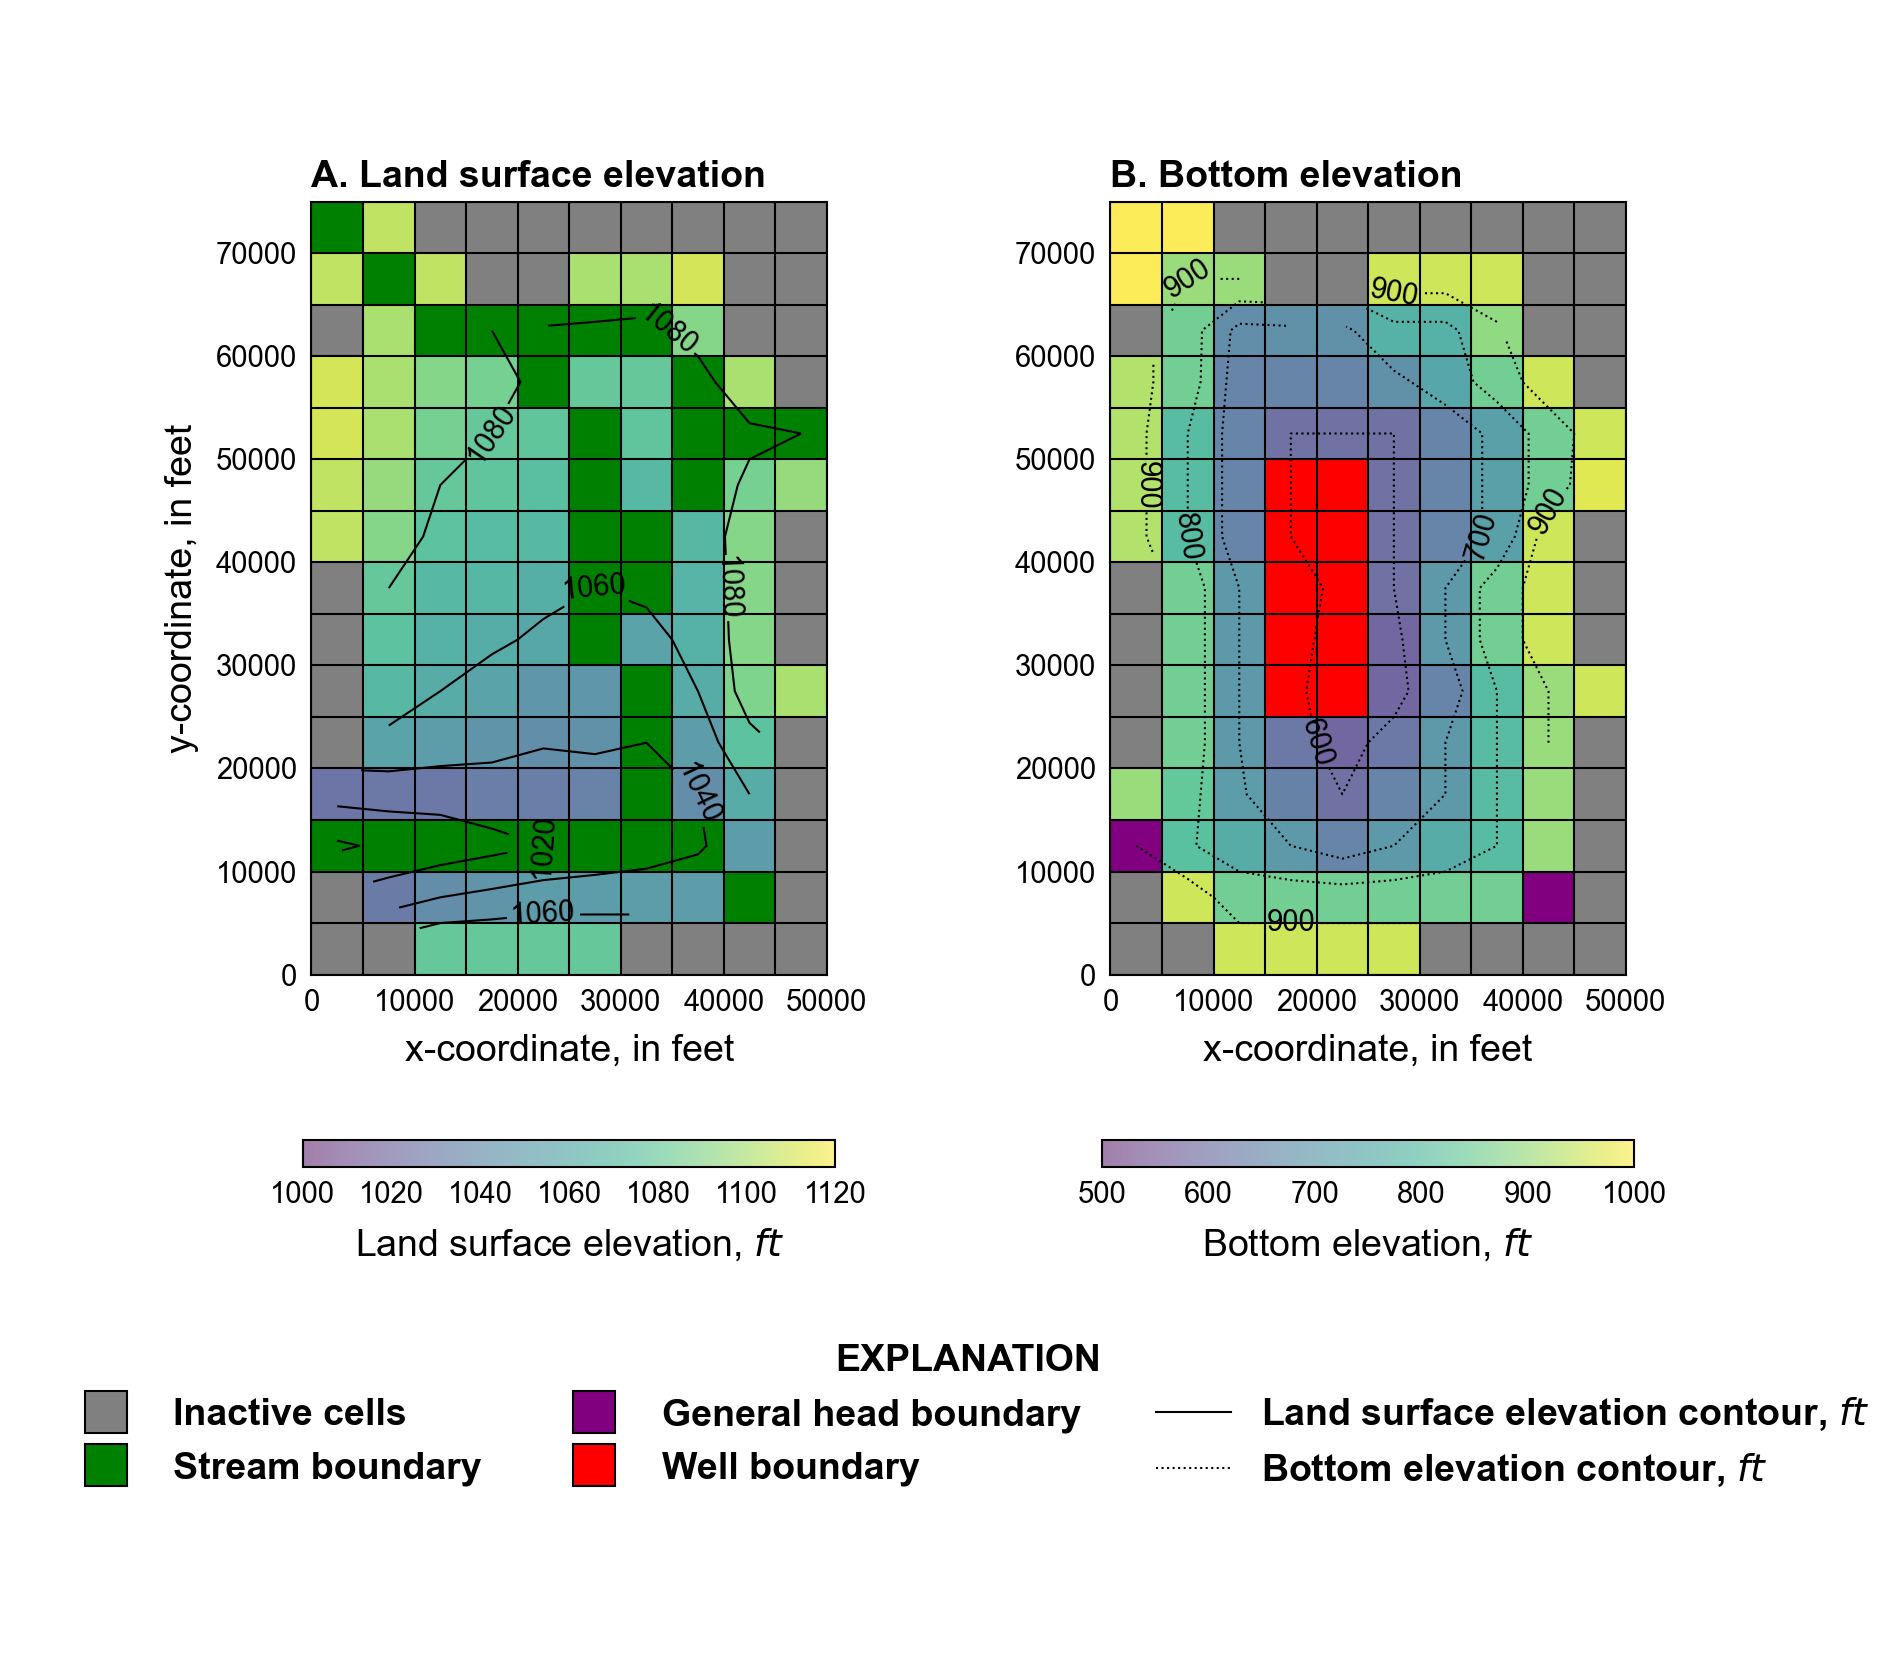
</div>

We are going to run the original model and then evaluate the other diversion priority constraints (`cprior`) to better understand how they function. The original model uses the `UPTO` priority constraint for the diversion from reach 4 to reach 10.

> `UPTO` – if Q$_{DS}$ in reach `IFNO` is $\ge$ to the specified diversion flow `DIVFLOW`, Q$_{DS}$ is reduced by `DIVFLOW`. If Q$_{DS}$ in reach `IFNO` is $\lt$ than `DIVFLOW`, `DIVFLOW` is set to Q$_{DS}$ and there will be no flow available for reaches connected to downstream end of reach `IFNO` for the diversion.

The same priority constraints are also used by the Mover (MVR) Package. See [Morway and others (2021)](https://doi.org/10.1111/gwat.13117) for more details on the MVR package.

## Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [ ]:
import datetime
import pathlib as pl

import flopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
from flopy.plot.styles import styles

Define the model name and workspace

In [ ]:
name = "sfr-p1"
ws = pl.Path(f"./temp/{name}")
data_name = "ex-gwf-sfr-p01"
data_path = ws / "data"

#### Define parameters

Define model units, parameters and other settings.

In [ ]:
# Model units
length_units = "feet"
time_units = "seconds"

# Model parameters
nper = 3  # Number of periods
nlay = 1  # Number of layers
nrow = 15  # Number of rows
ncol = 10  # Number of columns
delr = 5000.0  # Column width (ft)
delc = 5000.0  # Row width (ft)

strt = 1050.0  # Starting head (ft)

k11_stream = 0.002  # Hydraulic conductivity near the stream (ft/s)
k11_basin = 0.0004  # Hydraulic conductivity in the basin (ft/s)
ss = 1e-6  # Specific storage ($1/s)$

sy_stream = 0.2  # Specific yield near the stream (unitless)
sy_basin = 0.1  # Specific yield in the basin (unitless)

evap_rate = 9.5e-8  # Evapotranspiration rate (ft/s)
ext_depth = 15.0  # Evapotranspiration extinction depth (ft)

# Static temporal data used by TDIS file
tdis_ds = (
    (1.577880e9, 1, 1.0),
    (1.577880e9, 50, 1.1),
    (1.577880e9, 50, 1.1),
)

In [ ]:
# Define dimensions
extents = (0.0, delr * ncol, 0.0, delc * nrow)
shape2d = (nrow, ncol)
shape3d = (nlay, nrow, ncol)

In [ ]:
# Load the idomain, top, bottom, and evapotranspiration surface arrays
fname = "idomain.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{data_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash=None,
)
idomain = np.loadtxt(fpath, dtype=int)

fname = "top.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{data_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash=None,
)
top = np.loadtxt(fpath, dtype=float)

fname = "bottom.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{data_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash=None,
)
botm = np.loadtxt(fpath, dtype=float)

fname = "recharge.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{data_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash=None,
)
recharge = np.loadtxt(fpath, dtype=float)

fname = "surf.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{data_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash=None,
)
surf = np.loadtxt(fpath, dtype=float)

### Create hydraulic conductivity and specific yield data

In [ ]:
k11 = np.zeros(shape2d, dtype=float)
k11[idomain == 1] = k11_stream
k11[idomain == 2] = k11_basin

sy = np.zeros(shape2d, dtype=float)
sy[idomain == 1] = sy_stream
sy[idomain == 2] = sy_basin

### General head boundary conditions

In [ ]:
ghb_spd = [
    [0, 12, 0, 988.0, 0.038],
    [0, 13, 8, 1045.0, 0.038],
]

### Well boundary conditions

In [ ]:
wel_spd = {
    1: [
        [0, 5, 3, -10.0],
        [0, 5, 4, -10.0],
        [0, 6, 3, -10.0],
        [0, 6, 4, -10.0],
        [0, 7, 3, -10.0],
        [0, 7, 4, -10.0],
        [0, 8, 3, -10.0],
        [0, 8, 4, -10.0],
        [0, 9, 3, -10.0],
        [0, 9, 4, -10.0],
    ],
    2: [
        [],
    ],
}

### Create SFR data

In [ ]:
# Package data
# fmt: off
sfr_pakdata = [
    [0, 0, 0, 0, 4500.0, 12, 8.6767896e-04, 1093.048, 3.0, 0.00003, 0.030, 1, 1.0, 0],
    [1, 0, 1, 1, 7000.0, 12, 8.6767896e-04, 1088.059, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [2, 0, 2, 2, 6000.0, 12, 8.6767896e-04, 1082.419, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [3, 0, 2, 3, 5550.0, 12, 8.6767896e-04, 1077.408, 3.0, 0.00003, 0.030, 3, 1.0, 1],
    [4, 0, 3, 4, 6500.0, 12, 9.4339624e-04, 1071.934, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [5, 0, 4, 5, 5000.0, 12, 9.4339624e-04, 1066.509, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [6, 0, 5, 5, 5000.0, 12, 9.4339624e-04, 1061.792, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [7, 0, 6, 5, 5000.0, 12, 9.4339624e-04, 1057.075, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [8, 0, 7, 5, 5000.0, 12, 9.4339624e-04, 1052.359, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [9, 0, 2, 4, 5000.0, 10, 5.4545456e-04, 1073.636, 2.0, 0.00003, 0.030, 2, 0.0, 0],
    [10, 0, 2, 5, 5000.0, 10, 5.4545456e-04, 1070.909, 2.0, 0.00003, 0.030, 2, 1.0, 0],
    [11, 0, 2, 6, 4500.0, 10, 5.4545456e-04, 1068.318, 2.0, 0.00003, 0.030, 2, 1.0, 0],
    [12, 0, 3, 7, 6000.0, 10, 5.4545456e-04, 1065.455, 2.0, 0.00003, 0.030, 2, 1.0, 0],
    [13, 0, 4, 7, 5000.0, 10, 5.4545456e-04, 1062.455, 2.0, 0.00003, 0.030, 2, 1.0, 0],
    [14, 0, 5, 7, 2000.0, 10, 5.4545456e-04, 1060.545, 2.0, 0.00003, 0.030, 2, 1.0, 0],
    [15, 0, 4, 9, 2500.0, 10, 1.8181818e-03, 1077.727, 3.0, 0.00003, 0.030, 1, 1.0, 0],
    [16, 0, 4, 8, 5000.0, 10, 1.8181818e-03, 1070.909, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [17, 0, 5, 7, 3500.0, 10, 1.8181818e-03, 1063.182, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [18, 0, 5, 7, 4000.0, 15, 1.0000000e-03, 1058.000, 3.0, 0.00003, 0.030, 3, 1.0, 0],
    [19, 0, 6, 6, 5000.0, 15, 1.0000000e-03, 1053.500, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [20, 0, 7, 6, 3500.0, 15, 1.0000000e-03, 1049.250, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [21, 0, 7, 5, 2500.0, 15, 1.0000000e-03, 1046.250, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [22, 0, 8, 5, 5000.0, 12, 9.0909092e-04, 1042.727, 3.0, 0.00003, 0.030, 3, 1.0, 0],
    [23, 0, 9, 6, 5000.0, 12, 9.0909092e-04, 1038.182, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [24, 0, 10, 6, 5000.0, 12, 9.0909092e-04, 1033.636, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [25, 0, 11, 6, 5000.0, 12, 9.0909092e-04, 1029.091, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [26, 0, 12, 6, 2000.0, 12, 9.0909092e-04, 1025.909, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [27, 0, 13, 8, 5000.0, 55, 9.6774194e-04, 1037.581, 3.0, 0.00006, 0.025, 1, 1.0, 0],
    [28, 0, 12, 7, 5500.0, 55, 9.6774194e-04, 1032.500, 3.0, 0.00006, 0.025, 2, 1.0, 0],
    [29, 0, 12, 6, 5000.0, 55, 9.6774194e-04, 1027.419, 3.0, 0.00006, 0.025, 2, 1.0, 0],
    [30, 0, 12, 5, 5000.0, 40, 1.2500000e-03, 1021.875, 3.0, 0.00006, 0.025, 3, 1.0, 0],
    [31, 0, 12, 4, 5000.0, 40, 1.2500000e-03, 1015.625, 3.0, 0.00006, 0.025, 2, 1.0, 0],
    [32, 0, 12, 3, 5000.0, 40, 1.2500000e-03, 1009.375, 3.0, 0.00006, 0.025, 2, 1.0, 0],
    [33, 0, 12, 2, 5000.0, 40, 1.2500000e-03, 1003.125, 3.0, 0.00006, 0.025, 2, 1.0, 0],
    [34, 0, 12, 1, 5000.0, 40, 1.2500000e-03, 996.8750, 3.0, 0.00006, 0.025, 2, 1.0, 0],
    [35, 0, 12, 0, 3000.0, 40, 1.2500000e-03, 991.8750, 3.0, 0.00006, 0.025, 1, 1.0, 0],
]

In [ ]:
# sfr connection data
sfr_conn = [
    [0, -1],
    [1, 0, -2],
    [2, 1, -3],
    [3, 2, -4, -9],
    [4, 3, -5],
    [5, 4, -6],
    [6, 5, -7],
    [7, 6, -8],
    [8, 7, -22],
    [9, 3, -10],
    [10, 9, -11],
    [11, 10, -12],
    [12, 11, -13],
    [13, 12, -14],
    [14, 13, -18],
    [15, -16],
    [16, 15, -17],
    [17, 16, -18],
    [18, 14, 17, -19],
    [19, 18, -20],
    [20, 19, -21],
    [21, 20, -22],
    [22, 8, 21, -23],
    [23, 22, -24],
    [24, 23, -25],
    [25, 24, -26],
    [26, 25, -30],
    [27, -28],
    [28, 27, -29],
    [29, 28, -30],
    [30, 26, 29, -31],
    [31, 30, -32],
    [32, 31, -33],
    [33, 32, -34],
    [34, 33, -35],
    [35, 34],
]

In [ ]:
# sfr diversion data
sfr_div = [[3, 0, 9, "UPTO"]]

In [ ]:
# sfr stress period data
sfr_spd = [
    [0, "inflow", 25.0],
    [15, "inflow", 10.0],
    [27, "inflow", 150.0],
    [3, "diversion", 0, 15.0],  # was 10
    [9, "status", "simple"],
    [10, "status", "simple"],
    [11, "status", "simple"],
    [12, "status", "simple"],
    [13, "status", "simple"],
    [14, "status", "simple"],
    [9, "stage", 1075.545],
    [10, "stage", 1072.636],
    [11, "stage", 1069.873],
    [12, "stage", 1066.819],
    [13, "stage", 1063.619],
    [14, "stage", 1061.581],
]

### Solver parameters

In [ ]:
# Solver parameters
nouter = 500
ninner = 100
hclose = 1e-6
rclose = 1e-3

## Model setup

Create the MODFLOW packages for standard packages.

In [ ]:
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws)
flopy.mf6.ModflowTdis(
    sim, nper=nper, perioddata=tdis_ds, time_units=time_units
)
flopy.mf6.ModflowIms(
    sim,
    print_option="summary",
    linear_acceleration="bicgstab",
    outer_maximum=nouter,
    outer_dvclose=hclose,
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=f"{rclose} strict",
)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, newtonoptions="newton")
flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    idomain=idomain,
    top=top,
    botm=botm,
)

flopy.mf6.ModflowGwfnpf(
    gwf,
    icelltype=1,
    k=k11,
)

flopy.mf6.ModflowGwfsto(
    gwf,
    iconvert=1,
    sy=sy,
    ss=1e-5,
)
flopy.mf6.ModflowGwfic(gwf, strt=strt)

flopy.mf6.ModflowGwfghb(gwf, maxbound=len(ghb_spd), stress_period_data=ghb_spd)
flopy.mf6.ModflowGwfwel(
    gwf, maxbound=len(wel_spd[1]), stress_period_data=wel_spd
)
flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
flopy.mf6.ModflowGwfevta(gwf, surface=surf, rate=evap_rate, depth=ext_depth)

flopy.mf6.ModflowGwfoc(
    gwf,
    printrecord=[("BUDGET", "ALL")],
);

### Create the SFR package

In [ ]:
sfr = flopy.mf6.ModflowGwfsfr(
    gwf,
    length_conversion=3.28081,
    nreaches=len(sfr_pakdata),
    packagedata=sfr_pakdata,
    connectiondata=sfr_conn,
    diversions=sfr_div,
    perioddata=sfr_spd,
    pname="sfr-1",
)

In [ ]:
obs_file = f"{name}.sfr.obs"
csv_file = obs_file + ".csv"
obs_dict = {
    csv_file: [
        ("r04_flow", "downstream-flow", (3,)),
        ("r05_usflow", "upstream-flow", (4,)),
        ("r10_usflow", "upstream-flow", (9,)),
    ]
}
sfr.obs.initialize(filename=obs_file, print_input=True, continuous=obs_dict)

### Write the model files

In [ ]:
sim.write_simulation()

## Run the model

In [ ]:
sim.run_simulation()

## Plot Results


In [ ]:
# Figure properties
figure_size = (6.3, 5.6)

### Load the sfr observations

In [ ]:
def get_sfr_obs():
    arr = gwf.sfr.output.obs().data.copy()
    arr = np.insert(arr, 0, 0.0, axis=0)
    for name in arr.dtype.names[1:]:
        arr[name][0] = float(arr[name][1])
    arr["totim"] /= 86400.0
    arr["R04_FLOW"] *= -1.0

    init_date = datetime.datetime(1954, 7, 1, 12, 0, 0)
    sim_datetime = []
    for dt in arr["totim"]:
        sim_datetime.append(init_date + datetime.timedelta(days=dt))

    return pd.DataFrame.from_records(arr, index=sim_datetime).drop(
        columns=["totim"]
    )

In [ ]:
upto_df = get_sfr_obs()
upto_df

In [ ]:
upto_df.plot()

In [ ]:
sfr.diversions = [[3, 0, 9, "EXCESS"]]
sfr.write()
sim.run_simulation(silent=True)

In [ ]:
excess_df = get_sfr_obs()
excess_df

In [ ]:
upto_df["R10_USFLOW"].plot()
excess_df["R10_USFLOW"].plot()

In [ ]:
sfr.diversions = [[3, 0, 9, "THRESHOLD"]]
sfr.write()
sim.run_simulation(silent=True)

In [ ]:
threshold_df = get_sfr_obs()
threshold_df

In [ ]:
upto_df["R10_USFLOW"].plot()
excess_df["R10_USFLOW"].plot()
threshold_df["R10_USFLOW"].plot()

In [ ]:
sfr_spd[3]

In [ ]:
sfr_div = [[3, 0, 9, "FRACTION"]]
sfr_spd[3][3] = 0.5
sfr = flopy.mf6.ModflowGwfsfr(
    gwf,
    length_conversion=3.28081,
    nreaches=len(sfr_pakdata),
    packagedata=sfr_pakdata,
    connectiondata=sfr_conn,
    diversions=sfr_div,
    perioddata=sfr_spd,
    pname="sfr-1",
)
sfr.obs.initialize(filename=obs_file, print_input=True, continuous=obs_dict)
sfr.write()
sim.run_simulation(silent=True)

In [ ]:
fraction_df = get_sfr_obs()
fraction_df

In [ ]:
upto_df["R10_USFLOW"].plot()
excess_df["R10_USFLOW"].plot()
threshold_df["R10_USFLOW"].plot()
fraction_df["R10_USFLOW"].plot()